# Introduction to NLP

**Goal of the lab**: 
Given a set of Shakespeare play, can we:
- Find similarity across the different plays ?
- Find most frequent words per play ?
- Characterize the plays and interprete the results ?

## Pre-requisite
To run this lab, you need to have installed on your system:
- `pandas`
- `matplotlib`
- `seaborn`
- `spacy` (and the english extension by running `python -m spacy download en_core_web_sm`)
- `sklearn`

In [1]:
import pandas as pd
import seaborn as sns
import spacy
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [15, 5]

# Loading the dataset

The file `dataset.csv` contains the aggregated data of a set of Shakespeare's play.


> This is a reminder from yesterday's session !

In [11]:
df = pd.read_csv("data/dataset.csv", index_col=0)

**Exercice**:
1. Load the dataset located in "data/dataset.csv"
1. Give the number of individuals and list the columns in the dataset.
2. Give the number of unique plays in the dataset and output a list of them.

In [14]:
# 2.
print(f"There are {df.shape[0]} individuals in the dataset")
print(f"The available columns are: {df.columns}")

# 3
print(f"There are {len(df.Play.unique())} plays in the dataset")
print(f"Here are their names: {df.Play.unique()}")

There are 36 individuals in the dataset
The available columns are: Index(['Play', 'PlayerLine'], dtype='object')
There are 36 plays in the dataset
Here are their names: ['A Comedy of Errors' 'A Midsummer nights dream' 'A Winters Tale'
 'Alls well that ends well' 'Antony and Cleopatra' 'As you like it'
 'Coriolanus' 'Cymbeline' 'Hamlet' 'Henry IV' 'Henry V' 'Henry VI Part 1'
 'Henry VI Part 2' 'Henry VI Part 3' 'Henry VIII' 'Julius Caesar'
 'King John' 'King Lear' 'Loves Labours Lost' 'Measure for measure'
 'Merchant of Venice' 'Merry Wives of Windsor' 'Much Ado about nothing'
 'Othello' 'Pericles' 'Richard II' 'Richard III' 'Romeo and Juliet'
 'Taming of the Shrew' 'The Tempest' 'Timon of Athens' 'Titus Andronicus'
 'Troilus and Cressida' 'Twelfth Night' 'Two Gentlemen of Verona'
 'macbeth']


## Cleaning up the data
Textual should be:

- Lemmed
- Cleaned from stop words and punctuation.
  
We will do it using spacy built-in features.

In [4]:
nlp = spacy.load("en_core_web_sm")
# Take the first sentence from the dataset
test_sentence = df["PlayerLine"].iloc[0]
# Run it through spacy nlp function
doc = nlp(test_sentence)

# You can now iteratively access the different parsed version of the words
for token in doc[0:3]:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop)

A a DET DT det X True True
hall hall NOUN NN ROOT xxxx True False
in in ADP IN prep xx True True


**Exercice**:
1. Compute for each play the uncapitalized_text (using the `.lower()` function) and lemmed_text from spacy.
1. Add 2 new columns to the dataframe: `uncapitalized_text`and `lemmed_text`.

**Bonus**: Add a new column `cleaned_text` which contains the final text: start with the column `lemmed_text` and remove the stop words contained in `spacy.lang.en.stop_words.STOP_WORDS`.

In [26]:
# 1. We need to create two separate lists with the uncapitalized text and the lemmed text for each of the play
nlp = spacy.load("en_core_web_sm")

uncapitalized_text = []
lemmed_text = []
for sentence in df["PlayerLine"]:
    uncapitalized_text.append(sentence.lower())

    doc = nlp(sentence)
    lemmed_sentence = ""
    for token in doc:
        lemmed_sentence += token.lemma_.lower() + " "
    lemmed_text.append(lemmed_sentence)

# 2. These lists can now be assigned to the df as columns
df = df.assign(lemmed_text = lemmed_text)
df = df.assign(uncapitalized_text = uncapitalized_text)

# 3. Bonus: Create clean up function to remove stop words
def remove_stop_words(x):
    cleaned_sentence = ""
    for word in x.split():
        if word not in spacy.lang.en.stop_words.STOP_WORDS:
            cleaned_sentence += word + " "
    return cleaned_sentence

df = df.assign(cleaned_text = df.lemmed_text.apply(remove_stop_words))

## Analyzing vocabulary use

Using the `sklearn` library (see slides in lectures), it is easy to compute word counts using the `CountVectorizer` class.

In [30]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [128]:
# Initialize 
count_vect = CountVectorizer(stop_words=list(spacy.lang.en.STOP_WORDS))

# Fit on the clean column
count_vect.fit(df.cleaned_text)

# Get count matrix
count_matrix = count_vect.transform(df.cleaned_text).todense()

# Create as dataframe
count_df = pd.DataFrame(count_matrix, columns=count_vect.get_feature_names_out(), index=df.Play)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


`count_df` is now a dataframe where each column is a word and the rows correspond to the number of occurences of the words.

**Exercice**:
1. Give the 5 most frequent words across all plays, using count_df_.
2. Find for each play the number of times the word `love` and `death` is used.
3. Find the play that uses most often the word `love`.
5. Give for each play the most frequent word.

In [132]:
# 1. Sort count_df by frequency to get most frequent words
count_df.sum().sort_values(ascending=False)[:5]

# 2. Find frequency of love and death
count_df[["love", "death"]]

# 3. Find most frequent usage of word love
count_df["love"].sort_values(ascending=False)[:1]

# 4. For each play, find the most frequent word
for play_name, play_data in count_df.iterrows():
    print(f"Most frequent word for play: {play_name}")
    print(play_data.index[play_data.argmax()])
    print("====")

Most frequent word for play: A Comedy of Errors
antipholus
====
Most frequent word for play: A Midsummer nights dream
love
====
Most frequent word for play: A Winters Tale
thou
====
Most frequent word for play: Alls well that ends well
know
====
Most frequent word for play: Antony and Cleopatra
caesar
====
Most frequent word for play: As you like it
love
====
Most frequent word for play: Coriolanus
shall
====
Most frequent word for play: Cymbeline
thou
====
Most frequent word for play: Hamlet
lord
====
Most frequent word for play: Henry IV
thou
====
Most frequent word for play: Henry V
king
====
Most frequent word for play: Henry VI Part 1
thou
====
Most frequent word for play: Henry VI Part 2
thou
====
Most frequent word for play: Henry VI Part 3
thou
====
Most frequent word for play: Henry VIII
lord
====
Most frequent word for play: Julius Caesar
caesar
====
Most frequent word for play: King John
thou
====
Most frequent word for play: King Lear
thou
====
Most frequent word for play: 

## Projecting into a lower space

We are going to use `PCA` (see slides in lecture) to project the different books in a reduced 2 dimensional space and to visually analyze their similarity.

In [133]:
from sklearn.decomposition import PCA

# Reduce into a 2 dimension matrix
pca = PCA(n_components=2)

# Train and retrieve output
reduced_pca = pd.DataFrame(pca.fit_transform(count_df), columns=["axis_0","axis_1"])

**Exercice:**
1. Plot the scatter plot into the 2 dimensional space.
2. Color the graph per play.
3. Can you infer anything regarding the distribution in the reduced space ?

**Bonus**: 
- Find explained variance ratio using the attribute `pca.explained_variance_ratio_` and conclude regarding relevance of axis choice.

<Axes: xlabel='axis_0', ylabel='axis_1'>

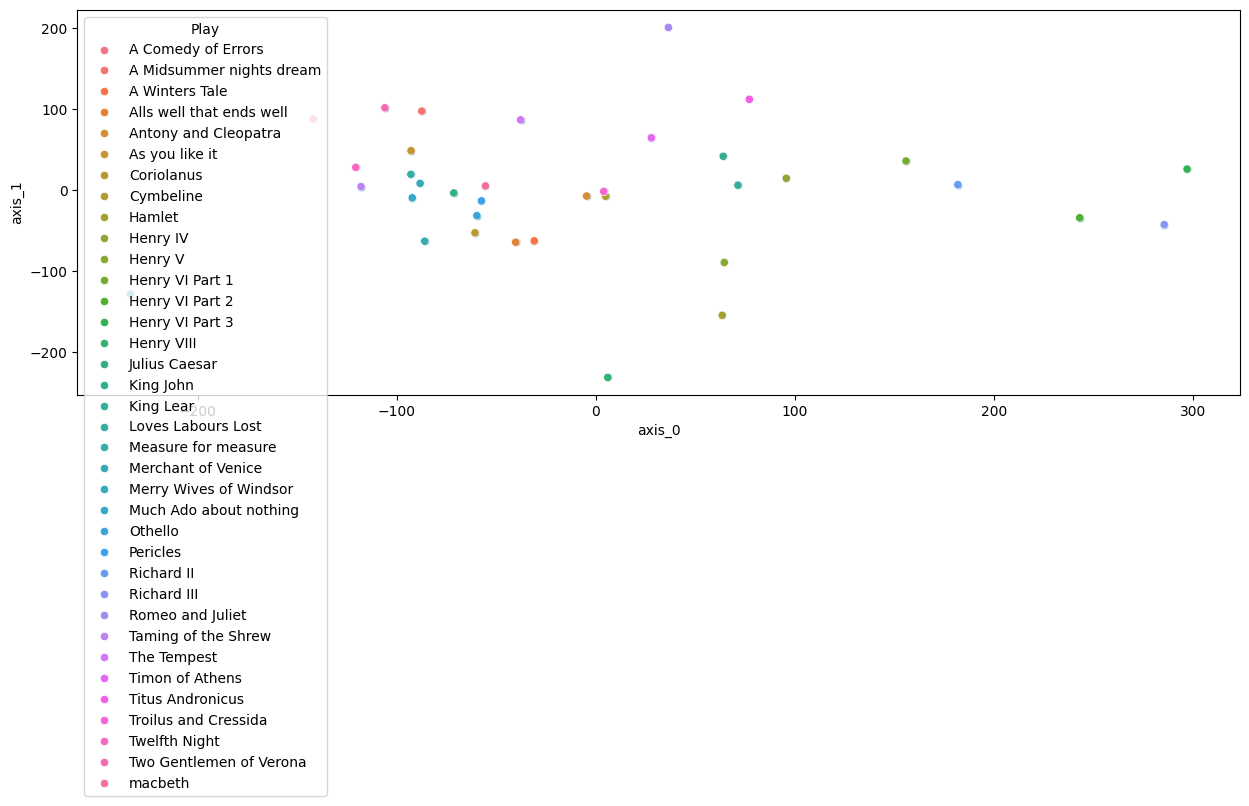

In [135]:
# 1. Plot the scatter plot in 2D
sns.scatterplot(x="axis_0", y="axis_1", data=reduced_pca)

# 2. Color the graph per play
sns.scatterplot(x="axis_0", y="axis_1", data=reduced_pca, hue=count_df.index)

# 3. TBD orally :-)


In [77]:
# Bonus questions

# Explained variance
print(pca.explained_variance_ratio_)

[0.17288498 0.07522315]


## Performing k-means clustering

We are going to use k-means clustering (see lecture slides) to group works that are the most similar in terms of vocabulary use, using the class `KMeans`. 

In [136]:
from sklearn.cluster import KMeans

kmeans= KMeans(n_clusters=5, n_init="auto")
kmeans.fit(count_df)
labels = kmeans.labels_

The `labels` list contains for each title its associated cluster.

**Exercice**:
1. Assign the `labels` column to the dataframe `count_df`.
4. Provide the list of plays within each cluster.
5. Give the 10 words with the highest term frequency per cluster.
6. Conclude regarding vocabulary overlap in Shakespeare's play.
   
**Bonus**:
1. Select the optimum number of clusters by analyzing the inertia for each value of k.
2. Test using the `DBScan` algorithm and compare results.

In [138]:
# 1. Labels columns to the dataframe
count_df = count_df.assign(labels=labels)

# 2. Iterate over the clusters
for label in pd.unique(count_df.labels):
    print(f"=== Cluster {label}")
    print(count_df[count_df.labels == label].index)

=== Cluster 2
Index(['A Comedy of Errors', 'A Midsummer nights dream',
       'Alls well that ends well', 'Henry V', 'Henry VIII', 'Julius Caesar',
       'Measure for measure', 'Merchant of Venice', 'Much Ado about nothing',
       'Pericles', 'The Tempest', 'macbeth'],
      dtype='object', name='Play')
=== Cluster 4
Index(['A Winters Tale', 'Antony and Cleopatra', 'Coriolanus', 'Cymbeline',
       'Hamlet', 'King Lear', 'Othello', 'Romeo and Juliet', 'Timon of Athens',
       'Troilus and Cressida'],
      dtype='object', name='Play')
=== Cluster 0
Index(['As you like it', 'Loves Labours Lost', 'Merry Wives of Windsor',
       'Taming of the Shrew', 'Twelfth Night', 'Two Gentlemen of Verona'],
      dtype='object', name='Play')
=== Cluster 1
Index(['Henry IV', 'Henry VI Part 1', 'Henry VI Part 2', 'Henry VI Part 3',
       'King John', 'Richard II', 'Richard III'],
      dtype='object', name='Play')
=== Cluster 3
Index(['Titus Andronicus'], dtype='object', name='Play')


In [142]:
# 3. Words with the highest frequency per cluster
for label in pd.unique(count_df.labels):
    print(f"=== Cluster {label}")
    print(count_df[count_df.labels == label].sum().sort_values(ascending=False)[:25])
    print("=====")

=== Cluster 2
thou     1281
shall    1042
come     1033
man       973
good      971
know      784
lord      758
thy       744
thee      744
sir       701
enter     684
love      668
let       640
hath      544
like      537
king      491
speak     483
think     432
hear      413
tell      403
time      369
god       355
day       352
look      348
tis       347
dtype: int64
=====
=== Cluster 4
thou     1702
come     1143
thy      1140
shall    1046
good     1034
thee      967
lord      958
man       878
let       793
enter     775
know      765
sir       754
love      739
like      570
speak     562
hath      549
tis       531
think     479
hear      420
tell      405
time      389
heart     383
look      373
great     363
eye       344
dtype: int64
=====
=== Cluster 0
sir         818
thou        699
love        685
come        644
good        569
shall       517
thy         480
thee        455
man         449
know        365
master      353
enter       345
let         339
like        

<Axes: >

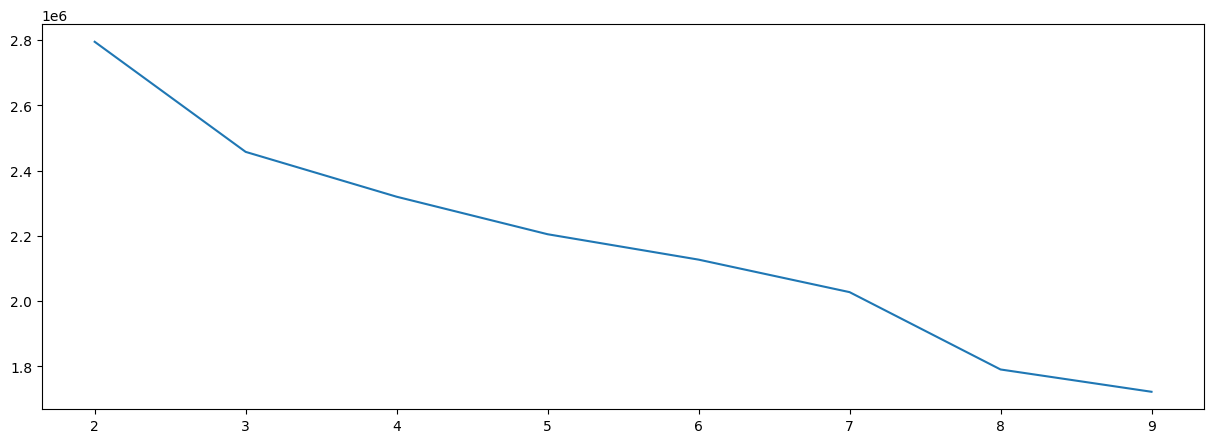

In [144]:
# Compute inertia
inertias=[]
for k in range(2, 10, 1):
    kmeans= KMeans(n_clusters=k, n_init="auto")
    kmeans.fit(count_df)
    inertias.append(kmeans.inertia_)

sns.lineplot(x=range(2, 10, 1), y=inertias)

**Bonus**: document embedding using Doc2Vec.

Another possible approach to embedding is the use of *neural networks* (we'll see tomorrow the practical behind these terms).
Many models exist for this embedding, and one of the most popular one is Doc2Vec.
This model is available in the library `gensim` (you can access the documentation here: https://radimrehurek.com/gensim/models/doc2vec.html).

> Do not forget to install `gensim` if you want this code to run !
> There is a slight hiccup as `gensim` requires a lower version of scipy, so you need additionally to run: `pip install scipy==1.12`.

In [146]:
# Load required libraries
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df.PlayerLine.values.tolist())]

# vector_size controls the dimension of the embeddings
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)
embeddings = pd.DataFrame([model.infer_vector(doc.split()) for doc in df.PlayerLine.values.tolist()], index=count_df.index)

**Exercice**:
1. Perform the clustering using k-means on the neural networks embedding and compare it to using count/tf-idf embedder.
2. Set the `vector_size` argument to 2 in order to get 2 dimension embeddings.
3. Plot the 2D embeddings, color and annotate according to play name and draw conclusions regarding plays similarity.

In [149]:
# 1. Perform kmeans clustering using embeddings instead
kmeans= KMeans(n_clusters=5, n_init="auto")
kmeans.fit(embeddings)
labels = kmeans.labels_

# Iterate over the clusters
for label in pd.unique(count_df.labels):
    print(f"=== Cluster {label}")
    print(count_df[count_df.labels == label].index)

=== Cluster 2
Index(['A Comedy of Errors', 'A Midsummer nights dream',
       'Alls well that ends well', 'Henry V', 'Henry VIII', 'Julius Caesar',
       'Measure for measure', 'Merchant of Venice', 'Much Ado about nothing',
       'Pericles', 'The Tempest', 'macbeth'],
      dtype='object', name='Play')
=== Cluster 4
Index(['A Winters Tale', 'Antony and Cleopatra', 'Coriolanus', 'Cymbeline',
       'Hamlet', 'King Lear', 'Othello', 'Romeo and Juliet', 'Timon of Athens',
       'Troilus and Cressida'],
      dtype='object', name='Play')
=== Cluster 0
Index(['As you like it', 'Loves Labours Lost', 'Merry Wives of Windsor',
       'Taming of the Shrew', 'Twelfth Night', 'Two Gentlemen of Verona'],
      dtype='object', name='Play')
=== Cluster 1
Index(['Henry IV', 'Henry VI Part 1', 'Henry VI Part 2', 'Henry VI Part 3',
       'King John', 'Richard II', 'Richard III'],
      dtype='object', name='Play')
=== Cluster 3
Index(['Titus Andronicus'], dtype='object', name='Play')


In [153]:
# 2 and 3. set embeddings to 2D
model = Doc2Vec(documents, vector_size=2, window=2, min_count=1, workers=4)
embeddings = pd.DataFrame([model.infer_vector(doc.split()) for doc in df.PlayerLine.values.tolist()], index=count_df.index, columns=["axis_0","axis_1"])

<Axes: xlabel='axis_0', ylabel='axis_1'>

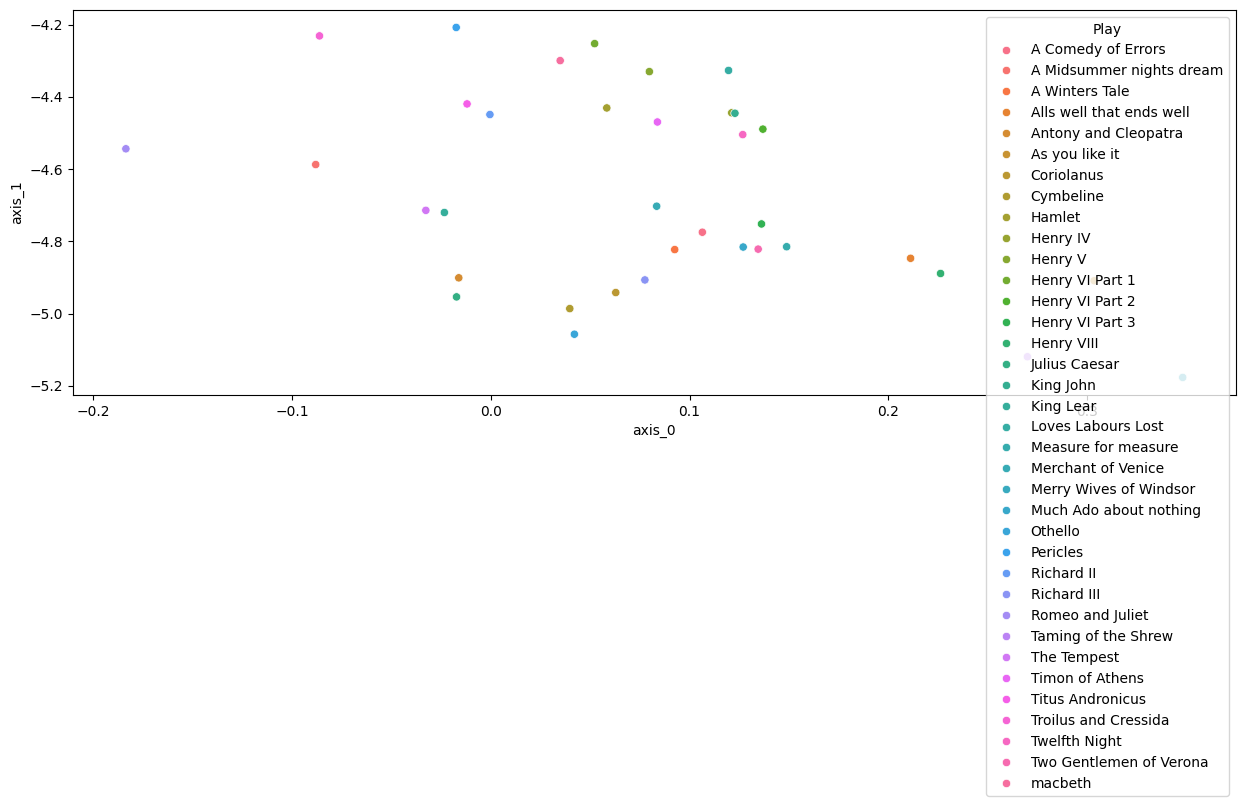

In [156]:
sns.scatterplot(x="axis_0", y="axis_1", data=embeddings, hue=embeddings.index)